# Supplementary Material: Analyse AdaptiveAttention

AdaptiveAttention is from the paper by Lu et al. (2017):

```
@inproceedings{lu2017knowing,
  title={Knowing when to look: Adaptive attention via a visual sentinel for image captioning},
  author={Lu, Jiasen and Xiong, Caiming and Parikh, Devi and Socher, Richard},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
  volume={6},
  pages={2},
  year={2017}
}
```

The following code depnds on pre-generated image captions using the implementation of the model from here:
https://github.com/jiasenlu/AdaptiveAttention
`seqs_test.npy`       : the generated sequence.
`attens_test.npy`     : the corresponding attentions.
`cocotalk_vocab.json` : the vocabulary provided with the model.

The generated sequences are for images in the validation images in MS-COCO:
http://images.cocodataset.org/zips/val2014.zip

```
@inproceedings{lin2014microsoft,
  title={Microsoft coco: Common objects in context},
  author={Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Doll{\'a}r, Piotr and Zitnick, C Lawrence},
  booktitle={European conference on computer vision},
  pages={740--755},
  year={2014},
  organization={Springer}
}
```

In [1]:
import numpy as np
from scipy.stats import spearmanr
import json
from nltk import pos_tag, tokenize
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from PIL import Image, ImageDraw

In [3]:
seqs = np.load('seqs_test.npy')[1:]
attens = np.load('attens_test.npy')[1:]
ix_to_word = json.load(open('cocotalk_vocab.json'))['ix_to_word']
ix_to_word = [ix_to_word[str(i+1)] for i in range(len(ix_to_word))]

In [4]:
en_preps = ['in', 'on', 'at', 'to', 'above', 'below', 'over', 'under']

# Landau English prepositions
en_preps = [
    # simple spatial relations
    'at', 'on', 'in', 'on', 'off',
    'out', 'by', 'from', 'to',
    'up', 'down', 'over', 'under',
    'with', ('within', 'with in'), ('without', 'with out'), 'near',
    'neadby', ('into', 'in to'), ('onto', 'on to'), 'toward',
    'through', 'throughout', 'underneath', 'along',
    'across', ('among', 'amongst'), 'against', 'around',
    'about', 'above', ('amid', 'amidst'), 'before',
    'behind', 'below', 'beneath', 'between',
    'beside', 'outside', 'inside', ('alongside', 'along side'),
    'via', 'after', 'upon', 
    # compounds
    ('top', 'on top of'), ('between', 'in between'), ('right', 'to the right of'), ('parallel', 'parallel to'),
    ('back', 'in back of'), ('left', 'to the left of'), ('side', 'to the side'), ('perpendicular', 'perpendicular to'),
    ('front', 'in front of'),
    # temporal only
    'during', 'since', 'until', 'ago',
    # intransitivies (+ additional variations)
    'here', 'outward', ('backward', 'backwards'), ('south' , 'south of'),
    'there', ('afterward', 'afterwards'), 'away', ('east', 'east of'),
    'upward', 'upstairs', 'apart', ('west', 'west of'),
    'downward', 'downstairs', 'together', 'left',
    'inward', 'sideways', ('north', 'north of'), 'right',
]


# Herskovits projective_terms
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'to', 'by'] for w2 in ['left', 'right'] ]
en_preps += [(w2, w1+' the '+w2+' side of')      for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' the '+w2+' hand side of') for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['front', 'back', 'side']]
en_preps += [(w1, 'in '+w1+' of')                for w1 in ['front', 'back']]
en_preps += [(w1,)                               for w1 in ['before', 'behind']]
en_preps += [(w1, w1+' of')                      for w1 in ['left', 'right', 'back']]
en_preps += [(w1,)                               for w1 in ['above', 'below']]
en_preps += [(w1,)                               for w1 in ['over', 'under']]
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'in', 'by'] for w2 in ['top', 'bottom']]
en_preps += [(w2, w1+' '+w2+' of')               for w1 in ['on'] for w2 in ['top']]

# missing items?
en_preps += [('next', 'next to'), ('front', 'on the front of', 'on front of', 'front of')]

# for those who lost 'the'
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'to', 'by'] for w2 in ['left', 'right'] ]
en_preps += [(w2, w1+' '+w2+' side of')      for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' '+w2+' hand side of') for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['front', 'back', 'side']]
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'in', 'by'] for w2 in ['top', 'bottom']]

# fix the tuple types
en_preps = [(w,) if type(w) != tuple else w for w in en_preps]

# This will create a ditionary of preposition variations to a simple tocken
composit2simple = dict()
composit2simple.update({w_alt: w[0] for w in en_preps for w_alt in w})
# every key is itself!
composit2simple.update({w: w        for w in composit2simple.values()})
# fix a common annotation with 'a', 'is', 'are'
composit2simple.update({new_w_alt: w     for w_alt, w in composit2simple.items() for new_w_alt in [w_alt + ' a', 'are ' + w_alt + ' a', 'is ' + w_alt + ' a', 'are ' + w_alt, 'is ' + w_alt]}) 

In [58]:
# basic keywords, just for presentation
spatial_key_words = [
    'left', 'right',
    'in', 'on',
    'over', 'above', 
    'below', 'under',
    'front', 'back',
    'next', 'near',
    'far', 'away',
    'between', 
]

# all keywords in Herskovits and all keywords in Landau
spatial_key_words = list(set(composit2simple.values()))

### Extract the attentions by part of speech 

In [37]:
seq_to_sent = lambda seq, ix_to_word: [ix_to_word[ix-1] for ix in seq if ix != 0 and ix-1 != len(ix_to_word)]

ix_scores = {i+1: [] for i in range(len(ix_to_word))}
for ix, score in zip(seqs.flatten(), attens[:,:, :1].flatten()):
    if ix in ix_scores:
        ix_scores[ix].append(1-score)
        
vocabs_scores = {
    ix_to_word[ix-1]: [np.mean(ix_scores[ix]), np.std(ix_scores[ix]), len(ix_scores[ix])] if len(ix_scores[ix]) > 0 else [0, 0, 0]
    for ix in ix_scores
}

In [67]:
pos_scores = {}

# left and right attentions on nouns
spatial_key_words_lr_attens = {
    w: np.zeros((0, 3, attens.shape[2]-1))
    for w in spatial_key_words
}

spatial_key_words_adaptive_attens = {
    w: np.zeros((0, 3, 1))
    for w in spatial_key_words
}

for seq, atten in zip(seqs, attens):
    sent = seq_to_sent(seq, ix_to_word)
    
    # POS tag report
    poses = list(zip(*pos_tag(sent, tagset='universal')))[1]
    for pos, score in zip(poses, atten[:len(sent), 0]):
        if pos in pos_scores:
            pos_scores[pos].append(1-score)
        else:
            pos_scores[pos]= [1-score]
    
    # spatial attention averaging
    for w in spatial_key_words_lr_attens:
        if w in sent:
            left_nouns = [i for i, pos in enumerate(poses) if i < sent.index(w) and pos == 'NOUN']
            right_nouns = [i for i, pos in enumerate(poses) if i > sent.index(w) and pos == 'NOUN']
            if len(left_nouns) == 0 or len(right_nouns) == 0:
                continue
            spatial_key_words_lr_attens[w] = np.concatenate([
                spatial_key_words_lr_attens[w],
                np.expand_dims(np.array([np.mean(atten[left_nouns, 1:], 0), atten[sent.index(w), 1:], np.mean(atten[right_nouns, 1:], 0)]), 0)
            ])

            spatial_key_words_adaptive_attens[w] = np.concatenate([
                spatial_key_words_adaptive_attens[w],
                np.expand_dims(np.array([np.mean(atten[left_nouns, 0:1], 0), atten[sent.index(w), 0:1], np.mean(atten[right_nouns, 0:1], 0)]), 0)
            ])


spatial_key_words_lr_attens_mean = {
    w: np.mean(spatial_key_words_lr_attens[w], 0)
    for w in spatial_key_words_lr_attens
    if spatial_key_words_lr_attens[w].shape[0] > 0
}

spatial_key_words_adaptive_attens_mean = {
    w: 1-np.mean(spatial_key_words_adaptive_attens[w], 0).reshape((3,))
    for w in spatial_key_words_adaptive_attens
    if spatial_key_words_adaptive_attens[w].shape[0] > 0
}

pos_scores = {
    pos: [np.mean(pos_scores[pos]), np.std(pos_scores[pos]), len(pos_scores[pos])] 
    for pos in pos_scores
}

In [68]:
spatial_key_words_adaptive_attens_mean

{'out': array([0.8199027 , 0.58777712, 0.78959851]),
 'outside': array([0.84390896, 0.73677717, 0.77095346]),
 'back': array([0.85165611, 0.68177129, 0.83914054]),
 'down': array([0.82452639, 0.66583599, 0.76031196]),
 'around': array([0.86623206, 0.73598049, 0.79350989]),
 'across': array([0.8025837 , 0.68873424, 0.78651336]),
 'near': array([0.80070054, 0.66908018, 0.7564056 ]),
 'along': array([0.79271873, 0.75448922, 0.74215637]),
 'in': array([0.81576084, 0.68002646, 0.77047188]),
 'about': array([0.78791057, 0.64860117, 0.64147086]),
 'over': array([0.76783755, 0.6234311 , 0.74551872]),
 'above': array([0.73112489, 0.64443777, 0.77088567]),
 'behind': array([0.86162396, 0.72438517, 0.76477205]),
 'into': array([0.8578097 , 0.61403757, 0.7465858 ]),
 'through': array([0.79961976, 0.66332763, 0.73421328]),
 'at': array([0.83001069, 0.70554156, 0.7376344 ]),
 'onto': array([0.80561089, 0.74750725, 0.85752276]),
 'with': array([0.79394786, 0.64664332, 0.72233415]),
 'off': array([0.7

### Visualizations and Reports 

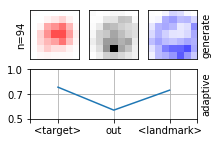

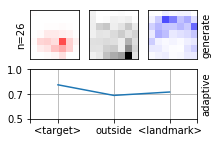

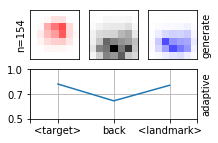

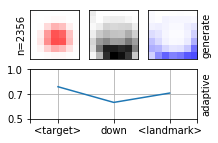

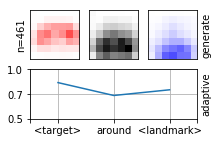

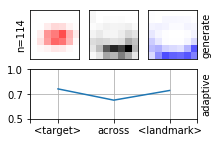

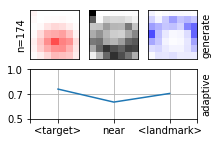

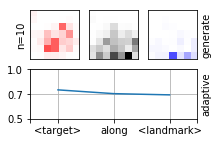

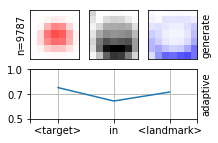

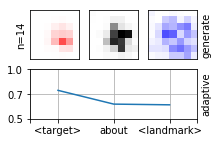

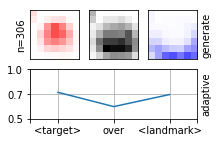

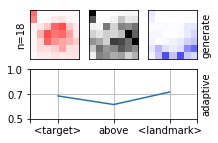

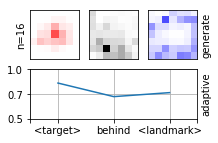

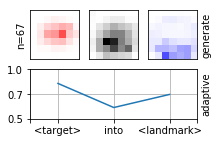

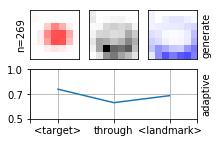

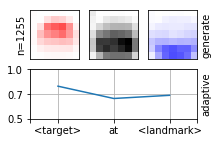

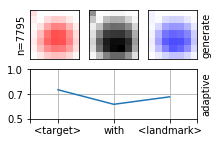

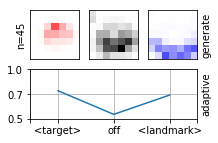

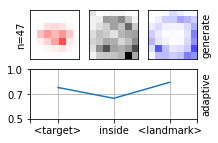

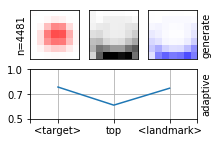

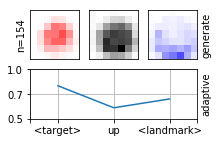

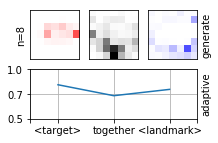

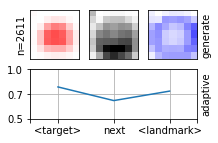

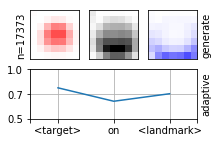

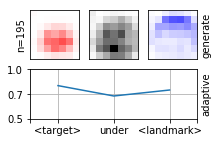

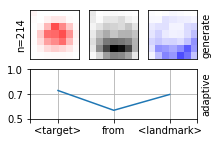

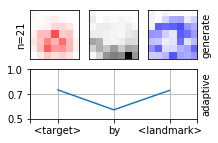

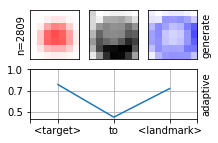

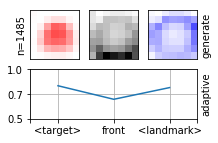

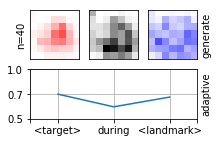

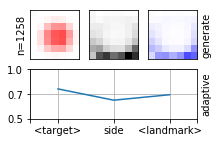

In [297]:
%matplotlib inline
# generate the colors for your colormap
red = (1.,0.,0.,.7)
red0 = (1.,0.,0.,.0)
blue = (0.,0.,1.,.7)
blue0 = (0.,0.,1.,.0)
white = (1.,1.,1.,1.)
black = (0.,0.,0.,1.)
grey = (.5,.5,.5,.5)

# make the colormaps
cmap_black = LinearSegmentedColormap.from_list('cmap_black',[white,black],256)
cmap_blue = LinearSegmentedColormap.from_list('cmap_blue',[blue0, blue,],256)
cmap_red = LinearSegmentedColormap.from_list('cmap_red',[red0, red,],256)
cmap_grey = LinearSegmentedColormap.from_list('cmap_grey',[white,black, ],256)

for index, w in enumerate(spatial_key_words):
    if spatial_key_words_lr_attens[w].shape[0] < 5:
        continue

    plt.figure(figsize=(3, 2))

    
    # the attentions
    
    # target
    ax = plt.subplot(2, 3, 1, )
    plt.ylabel('n={count}'.format(count=spatial_key_words_lr_attens[w].shape[0] if w in spatial_key_words_lr_attens_mean else 0))
    plt.imshow(np.zeros((7,7)), cmap=cmap_black)    
    plt.imshow(spatial_key_words_lr_attens_mean[w][0].reshape((7,7))**5, cmap=cmap_red)
    plt.xticks([])
    plt.yticks([])
    

    # relation
    ax = plt.subplot(2, 3, 2, )
    plt.imshow(np.zeros((7,7)), cmap=cmap_black)    
    plt.imshow(spatial_key_words_lr_attens_mean[w][1].reshape((7,7))**5, cmap=cmap_grey)
    plt.xticks([])
    plt.yticks([])
    

    # landmark
    ax = plt.subplot(2, 3, 3, )
    ax.yaxis.set_label_text('generate')
    ax.yaxis.set_label_position("right")
    plt.imshow(np.zeros((7,7)), cmap=cmap_black)    
    plt.imshow(spatial_key_words_lr_attens_mean[w][2].reshape((7,7))**5, cmap=cmap_blue)
    plt.xticks([])
    plt.yticks([])
    

    # adaptive attention
    ax = plt.subplot(2, 1, 2, )
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    #plt.title('{word}'.format(word=w))
    plt.ylabel('adaptive')
    ax.yaxis.set_label_position("right")
    plt.plot([1, 2, 3], spatial_key_words_adaptive_attens_mean[w])
    plt.xticks([0.5,1,2,3,3.5], ['', '<target>', w, '<landmark>', ''])
    plt.yticks([0.5, 0.75, 1.], ['0.5', '0.7', '1.0'])
    plt.grid(True)

    plt.savefig('reports/{0}-adaptive.pdf'.format(w))
    plt.show()
    

In [334]:
print("{word:8} {union:5} {target:5} {landmark:5} {trglnd:5}".format(
    word="word",
    union="uni",
    target="trg",
    landmark="lnd",
    trglnd="trglnd",
))
for index, w in enumerate(spatial_key_words):
    if spatial_key_words_lr_attens[w].shape[0] < 5:
        continue
        
    union=spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w][0]+spatial_key_words_lr_attens_mean[w][2]).correlation
    target=spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w][0]).correlation
    landmark=spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w][2]).correlation
    trglnd=spearmanr(spatial_key_words_lr_attens_mean[w][0], spatial_key_words_lr_attens_mean[w][2]).correlation
    measure=spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w][0]+spatial_key_words_lr_attens_mean[w][2] - spatial_key_words_lr_attens_mean[w][0]*spatial_key_words_lr_attens_mean[w][2]).correlation

    others=0
    count=0
    for w0 in spatial_key_words:
        if spatial_key_words_lr_attens[w0].shape[0] < 5 and w != w0:
            continue
        others+=spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w0][0]+spatial_key_words_lr_attens_mean[w0][2]).correlation
        count+=1
    others = others/count
    
    std_trg=(np.max(spatial_key_words_lr_attens_mean[w][0])-np.min(spatial_key_words_lr_attens_mean[w][0]))
    std_rel=(np.max(spatial_key_words_lr_attens_mean[w][1])-np.min(spatial_key_words_lr_attens_mean[w][1]))
    std_lnd=(np.max(spatial_key_words_lr_attens_mean[w][2])-np.min(spatial_key_words_lr_attens_mean[w][2]))

    print("{word:8} {union:5.2f} & {target:5.2f} & {landmark:5.2f} & {others:5.2f} {trglnd:5.2f} {random:5.2f} {measure} {std_trg:5.4f} & {std_rel:5.4f} & {std_lnd:5.4f}".format(
        word=w,
        union=union,
        target=target,
        landmark=landmark,
        others=others,
        trglnd=trglnd,
        random=spearmanr(np.random.rand(49), spatial_key_words_lr_attens_mean[w][0]+spatial_key_words_lr_attens_mean[w][2]).correlation,
        #measure=union/others \
                #spearmanr(spatial_key_words_lr_attens_mean[w][1], spatial_key_words_lr_attens_mean[w][0]+spatial_key_words_lr_attens_mean[w][2] - spatial_key_words_lr_attens_mean[w][0]*spatial_key_words_lr_attens_mean[w][2]).correlation \
                #- spearmanr(spatial_key_words_lr_attens_mean[w][0], spatial_key_words_lr_attens_mean[w][2]).correlation \
                #+ (1 - ) \
        measure="${0:0.2f} \pm {1:0.1f}$, ${2:0.2f} \pm {3:0.1f}$, ${4:0.2f} \pm {5:0.1f}$".format(
            1-np.mean(spatial_key_words_adaptive_attens[w],0).flatten()[0],
            np.std(spatial_key_words_adaptive_attens[w],0).flatten()[0],
            1-np.mean(spatial_key_words_adaptive_attens[w],0).flatten()[1],
            np.std(spatial_key_words_adaptive_attens[w],0).flatten()[1],
            1-np.mean(spatial_key_words_adaptive_attens[w],0).flatten()[2],
            np.std(spatial_key_words_adaptive_attens[w],0).flatten()[2],
        )
                ,
        std_trg=std_trg,
        std_rel=std_rel,
        std_lnd=std_lnd,
    ))

    

word     uni   trg   lnd   trglnd
out       0.93 &  0.87 &  0.60 &  0.85  0.35  0.11 $0.82 \pm 0.1$, $0.59 \pm 0.1$, $0.79 \pm 0.1$ 0.0248 & 0.0160 & 0.0155
outside   0.63 &  0.69 &  0.06 &  0.64 -0.16 -0.14 $0.84 \pm 0.1$, $0.74 \pm 0.1$, $0.77 \pm 0.1$ 0.0351 & 0.0190 & 0.0173
back      0.75 &  0.48 &  0.96 &  0.78  0.64 -0.11 $0.85 \pm 0.1$, $0.68 \pm 0.1$, $0.84 \pm 0.1$ 0.0332 & 0.0186 & 0.0272
down      0.88 &  0.72 &  0.66 &  0.74  0.11  0.03 $0.82 \pm 0.1$, $0.67 \pm 0.1$, $0.76 \pm 0.1$ 0.0285 & 0.0166 & 0.0190
around    0.84 &  0.53 &  0.93 &  0.79  0.37  0.03 $0.87 \pm 0.1$, $0.74 \pm 0.1$, $0.79 \pm 0.1$ 0.0242 & 0.0176 & 0.0188
across    0.79 &  0.55 &  0.73 &  0.67  0.03 -0.18 $0.80 \pm 0.1$, $0.69 \pm 0.1$, $0.79 \pm 0.1$ 0.0331 & 0.0212 & 0.0225
near      0.70 &  0.66 &  0.25 &  0.51 -0.09 -0.11 $0.80 \pm 0.1$, $0.67 \pm 0.1$, $0.76 \pm 0.1$ 0.0221 & 0.0133 & 0.0169
along     0.86 &  0.62 &  0.85 &  0.63  0.39  0.09 $0.79 \pm 0.1$, $0.75 \pm 0.1$, $0.74 \pm 0.1$ 0.0298 

In [57]:
pos_scores

{'DET': [0.7264259751509171, 0.11532400718610028, 96641],
 'ADJ': [0.7672038908350629, 0.14376983932921442, 23670],
 'NOUN': [0.7758089489907198, 0.12399206128128708, 134332],
 'ADP': [0.6225638252947678, 0.14994317410343047, 64332],
 'VERB': [0.7044951082819595, 0.11214186592805478, 38381],
 'PRT': [0.5246588716249427, 0.207953208577676, 6462],
 'CONJ': [0.7001670506347845, 0.13031564469168938, 6755],
 'PRON': [0.5333353063106715, 0.13635825065251472, 2347],
 'NUM': [0.8084652950902105, 0.08481469091384072, 1882],
 'ADV': [0.6937863861575074, 0.12391898081322543, 184],
 '.': [0.7157025188207626, 0.05320121347904205, 2]}

In [42]:
spatial_key_words = [
    'left', 'right',
    'in', 'on',
    'over', 'above', 
    'below', 'under',
    'front', 'back',
    'next', 'near',
    'far', 'away',
    'between', 
]
spatial_key_words = [
    w for w in set(composit2simple.values())
    if w in vocabs_scores
]
some_objects = [
    'cat', 'dog',
    'man', 'woman',
    'cup', 'plate',
    'table', 'chair',
    'pen', 'book',
    'laptop', 'pizza',
    'tree', 'road',
    'building', 'mountain'
]
some_properties = [
    'red', 'green', 'blue', 'black', 'white', 'grey', 'purple',
    'big', 'small', 
    'tall', 'short',
]
some_numers = [
    'one', 'two', 'three', 'four', 'five', 'six'
]
some_verbs = [
    'jumping', 'running', 'eating',
    'jump', 'run', 'eat',
]
some_verbs_aux = [
    'is', 'are', 'does',
    'can', 'could', 'will', 'would'
]
det_indices = [
    'a', 'the', 
    'this', 'that', 'there', 
]
other_words = [
    'from', 'to', 'for',
]
some_pronouns = [
    'she', 'he', 'it', 'they',
    'her', 'his', 'him', 'its', 'them',
]

categories = {
    'spatial': spatial_key_words,
    'objects': some_objects,
    'properties': some_properties,
    'numers': some_numers,
    'verbs': some_verbs,
    'verbs_aux': some_verbs_aux,
    'others': other_words,
    'pronouns': some_pronouns,
    'det_indices': det_indices
}

print('{word}\t{count}\t${mean}\pm{std}$'.format(mean='mean',std='std',count='count',word='word'))


cat = 'pos'
print((14-int(len(cat)/2))*'-', cat, (14-int(len(cat)/2))*'-')
poses = list(pos_scores.keys())
poses.sort(key=lambda w: pos_scores[w][0], reverse=True)
for w in poses:
    print('{word}\t& {count}\t& ${mean:0.2f} \pm {std:0.2f}$ \\\\'.format(
        mean=pos_scores[w][0],
        std=pos_scores[w][1],
        count=pos_scores[w][2],
        word=w
    ))

for cat in categories:
    print((14-int(len(cat)/2))*'-', cat, (14-int(len(cat)/2))*'-')

    # sort the word category:
    categories[cat].sort(key=lambda w: vocabs_scores[w][0], reverse=True)
    
    for w in categories[cat]:
        if vocabs_scores[w][2] == 0:
            continue
        print('{word}\t& {count}\t& ${mean:0.2f} \pm {std:0.2f}$ \\\\'.format(
            mean=vocabs_scores[w][0],
            std=vocabs_scores[w][1],
            count=vocabs_scores[w][2],
            word=w
        ))



word	count	$mean\pmstd$
------------- pos -------------
NUM	& 1882	& $0.81 \pm 0.08$ \\
NOUN	& 134332	& $0.78 \pm 0.12$ \\
ADJ	& 23670	& $0.77 \pm 0.14$ \\
DET	& 96641	& $0.73 \pm 0.12$ \\
.	& 2	& $0.72 \pm 0.05$ \\
VERB	& 38381	& $0.70 \pm 0.11$ \\
CONJ	& 6755	& $0.70 \pm 0.13$ \\
ADV	& 184	& $0.69 \pm 0.12$ \\
ADP	& 64332	& $0.62 \pm 0.15$ \\
PRON	& 2347	& $0.53 \pm 0.14$ \\
PRT	& 6462	& $0.52 \pm 0.21$ \\
----------- spatial -----------
without	& 1	& $0.86 \pm 0.00$ \\
underneath	& 1	& $0.81 \pm 0.00$ \\
along	& 10	& $0.75 \pm 0.07$ \\
onto	& 2	& $0.75 \pm 0.06$ \\
outside	& 36	& $0.74 \pm 0.08$ \\
around	& 471	& $0.74 \pm 0.09$ \\
under	& 209	& $0.73 \pm 0.11$ \\
there	& 36	& $0.73 \pm 0.09$ \\
behind	& 19	& $0.71 \pm 0.13$ \\
at	& 1278	& $0.70 \pm 0.13$ \\
after	& 1	& $0.69 \pm 0.00$ \\
inside	& 54	& $0.69 \pm 0.11$ \\
front	& 1563	& $0.69 \pm 0.15$ \\
across	& 114	& $0.69 \pm 0.08$ \\
left	& 2	& $0.69 \pm 0.06$ \\
side	& 1321	& $0.69 \pm 0.13$ \\
next	& 3640	& $0.68 \pm 0.12$ \\
